In [1]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import matplotlib
matplotlib.pyplot.rc('text', usetex=True)

#### The shortest common superstring problem is the challenge of finding the shortest string that contains every string in a given set as a substring. In genomic data science, this problem is central to genome assembly: sequencing machines produce many short reads, and assembling them into a complete genome requires finding a superstring that covers all the reads. However, the problem is NP-hard, meaning that finding an optimal solution is computationally intensive, so heuristic or approximate algorithms are typically used in practice.








In [2]:
# First we define the overlap function
def optimized_overlap(a, b, min_length=3):
    """
    Return the length of the longest suffix of 'a' that matches a prefix of 'b'
    that is at least 'min_length' characters long. If no such overlap exists, return 0.

    This implementation starts checking from the maximum possible overlap length 
    and iterates downward until it finds a match.

    Args:
        a (str): The first string.
        b (str): The second string.
        min_length (int): The minimum overlap length required.

    Returns:
        int: The length of the longest valid overlap, or 0 if no such overlap exists.
    """
    max_overlap = min(len(a), len(b))
    for L in range(max_overlap, min_length - 1, -1):
        if a[-L:] == b[:L]:
            return L
    return 0


In [3]:
# Example usage:
a = "GCTAGCTA"
b = "CTAAGGTC"
print("Overlap length:", optimized_overlap(a, b, min_length=3))

Overlap length: 3


#### To keep in mind the shortest common superstring problem is NP complete

In [6]:
import itertools

def optimized_scs(ss):
    """
    Returns the shortest common superstring (SCS) of a set of strings,
    assuming no string is a strict substring of another.
    
    This function precomputes pairwise overlaps between strings and uses
    branch-and-bound to prune permutations that already exceed the length
    of the current best superstring.
    
    Args:
        ss (list): A list of strings.
    
    Returns:
        str: The shortest common superstring.
    """
    # Precompute overlaps for every ordered pair of strings in ss.
    overlaps = {}
    for a, b in itertools.permutations(ss, 2):
        overlaps[(a, b)] = optimized_overlap(a, b, min_length=1)
    
    shortest_sup = None
    # Iterate over all permutations of ss
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]
        # Build the superstring by merging each adjacent pair using the precomputed overlaps.
        for i in range(len(ss) - 1):
            olen = overlaps[(ssperm[i], ssperm[i+1])]
            sup += ssperm[i+1][olen:]
            # Prune if the candidate superstring is already longer than the best one found.
            if shortest_sup is not None and len(sup) >= len(shortest_sup):
                break
        else:
            if shortest_sup is None or len(sup) < len(shortest_sup):
                shortest_sup = sup
    return shortest_sup

In [7]:
# Example usage:
ss = ["GATTA", "ATTAC", "TACAG", "CAGAT"]
print("Shortest common superstring:", optimized_scs(ss))

Shortest common superstring: GATTACAGAT


In [8]:
optimized_scs(['ACGGATGAGC', 'GAGCGGA', 'GAGCGAG'])

'ACGGATGAGCGAGCGGA'

### Greedy shortest common superstring

In [14]:
import itertools

def optimized_pick_maximal_overlap(reads, k):
    """
    Return a pair of reads (a, b) from the list with the maximal suffix/prefix overlap of at least k characters,
    and the length of that overlap. If no such overlap exists, return (None, None, 0).

    This optimized version builds a dictionary mapping k-mer prefixes to reads, so that for each read 'a',
    we only compare it to those reads 'b' whose prefix of length k matches 'a's suffix of length k.

    Args:
        reads (list of str): A list of read sequences.
        k (int): Minimum overlap length required.

    Returns:
        tuple: (read_a, read_b, best_overlap_length)
    """
    # Build an index: map each k-mer prefix to the list of reads that start with that k-mer.
    prefix_index = {}
    for read in reads:
        prefix = read[:k]
        prefix_index.setdefault(prefix, []).append(read)
    
    best_olen = 0
    reada, readb = None, None
    
    # For each read 'a', consider only those reads that have a prefix matching 'a's suffix.
    for a in reads:
        suffix = a[-k:]
        # Only proceed if some reads start with the same k-mer as the suffix of a.
        if suffix in prefix_index:
            for b in prefix_index[suffix]:
                # Avoid self-overlap.
                if a == b:
                    continue
                # Compute the overlap length (which could be longer than k).
                olen = optimized_overlap(a, b, min_length=k)
                if olen > best_olen:
                    best_olen = olen
                    reada, readb = a, b
                    
    return reada, readb, best_olen



def optimized_greedy_scs(reads, k):
    """
    Greedy shortest-common-superstring merge algorithm.
    
    Repeatedly finds and merges the pair of reads with the maximal suffix/prefix
    overlap of at least k characters, until no such overlaps remain.
    
    This version uses a list comprehension to remove the merged reads, which can
    be more efficient than calling .remove() repeatedly.
    
    Args:
        reads (list of str): List of read sequences.
        k (int): Minimum overlap length required.
        
    Returns:
        str: The shortest common superstring obtained from merging the reads.
    """
    while True:
        # Pick the pair with maximal overlap (and its overlap length)
        read_a, read_b, olen = optimized_pick_maximal_overlap(reads, k)
        if olen == 0:
            break  # No overlap meeting the criteria; stop merging.
        
        # Merge read_a and read_b using their overlap.
        merged = read_a + read_b[olen:]
        
        # Remove the two reads and add the merged read.
        reads = [r for r in reads if r != read_a and r != read_b]
        reads.append(merged)
        
    # If more than one read remains, simply join them (this may happen if no overlaps exist).
    return reads[0] if len(reads) == 1 else ''.join(reads)


In [17]:
# Example usage:
reads = [
    "GATTA", 
    "ATTAC", 
    "TACAG", 
    "CAGAT"
]
print("Maximal overlap:", optimized_pick_maximal_overlap(reads, 3))

print(optimized_greedy_scs(['ABC', 'BCA', 'CAB'], 2))
print(optimized_scs(['ABC', 'BCA', 'CAB']))

Maximal overlap: ('ATTAC', 'TACAG', 3)
CABCA
ABCAB


BBBAAABBA


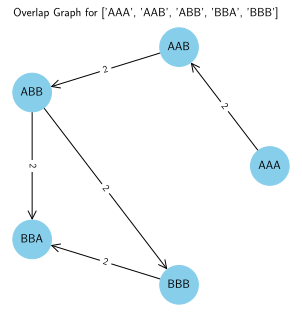

In [21]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

def optimized_overlap(a, b, min_length=3):
    """
    Return the length of the longest suffix of 'a' matching a prefix of 'b'
    that is at least 'min_length' characters long. If no such overlap exists, return 0.
    
    This implementation checks candidate overlaps in descending order.
    """
    max_overlap = min(len(a), len(b))
    for L in range(max_overlap, min_length - 1, -1):
        if a[-L:] == b[:L]:
            return L
    return 0

def build_overlap_graph(reads, k):
    """
    Build an overlap graph from the given list of reads.
    
    Args:
        reads (list of str): List of read sequences.
        k (int): Minimum overlap length required.
    
    Returns:
        networkx.DiGraph: A directed graph where an edge from A to B exists if
                           the suffix of A overlaps the prefix of B by at least k bases.
    """
    G = nx.DiGraph()
    for a, b in itertools.permutations(reads, 2):
        olen = optimized_overlap(a, b, min_length=k)
        if olen > 0:
            G.add_edge(a, b, weight=olen)
    return G

# Define the set of reads and the minimum overlap k.
reads = ['AAA', 'AAB', 'ABB', 'BBA', 'BBB']
k = 2

# Build the overlap graph.
G = build_overlap_graph(reads, k)

# Use a circular layout for clarity.
pos = nx.circular_layout(G)

# Plot the graph.
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", 
        arrows=True, arrowstyle='->', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Overlap Graph for ['AAA', 'AAB', 'ABB', 'BBA', 'BBB']")
print(optimized_greedy_scs(reads, 2))
plt.show()

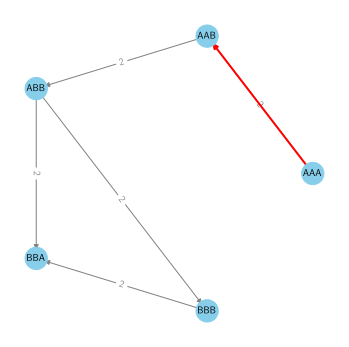

In [24]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import random

def optimized_overlap(a, b, min_length=3):
    """
    Return the length of the longest suffix of 'a' matching a prefix of 'b'
    that is at least 'min_length' characters long. If no such overlap exists, return 0.
    """
    max_overlap = min(len(a), len(b))
    for L in range(max_overlap, min_length - 1, -1):
        if a[-L:] == b[:L]:
            return L
    return 0

def pick_maximal_overlap(reads, k):
    """
    Return a pair of reads (a, b) from the list with a maximal suffix/prefix overlap
    of at least k characters, along with the overlap length.
    Returns (None, None, 0) if no such overlap exists.
    """
    reada, readb = None, None
    best_olen = 0
    for a, b in itertools.permutations(reads, 2):
        olen = optimized_overlap(a, b, min_length=k)
        if olen > best_olen:
            reada, readb = a, b
            best_olen = olen
    return reada, readb, best_olen

def build_overlap_graph(reads, k):
    """
    Build an overlap graph from a list of reads.
    Nodes are reads and a directed edge from read A to read B indicates that
    A's suffix overlaps B's prefix by at least k characters.
    """
    G = nx.DiGraph()
    for a, b in itertools.permutations(reads, 2):
        olen = optimized_overlap(a, b, min_length=k)
        if olen > 0:
            G.add_edge(a, b, weight=olen)
    return G

def visualize_optimized_scs_step(reads, k):
    """
    Visualize one merge step of the optimized greedy SCS algorithm.
    
    This function builds the overlap graph for the current set of reads, then picks the edge with
    the maximal overlap (using pick_maximal_overlap) and highlights it in red.
    
    Args:
        reads (list): List of read strings.
        k (int): Minimum overlap length required.
    """
    # Build the overlap graph.
    G = build_overlap_graph(reads, k)
    # Get the best overlap edge.
    reada, readb, best_olen = pick_maximal_overlap(reads, k)
    
    # Compute layout (using a circular layout for clarity).
    pos = nx.circular_layout(G)
    
    plt.figure(figsize=(6,6))
    # Draw all nodes and edges in light colors.
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
    
    # Highlight the best overlap edge if it exists.
    if best_olen > 0:
        nx.draw_networkx_edges(G, pos, edgelist=[(reada, readb)], edge_color='red', width=2, arrows=True)
        #plt.title(f"Merge Step: '{reada}' -> '{readb}' (overlap = {best_olen})")
    else:
        plt.title("No valid merge edge found")
    
    plt.axis("off")
    plt.show()

# Example usage:
reads = ['AAA', 'AAB', 'ABB', 'BBA', 'BBB']
k = 2
visualize_optimized_scs_step(reads, k)


## De Bruijn graphs and Eulerian walks

### Utility of De Bruijn Graphs and Eulerian Walks

De Bruijn graphs and Eulerian walks are powerful tools in genomic data science, especially for genome assembly. Their main utilities include:

- **Efficient Genome Assembly:**  
  De Bruijn graphs break down sequencing reads into k-mers, where nodes represent k-mers (or (k–1)-mers) and directed edges represent the overlap between adjacent k-mers. An Eulerian walk (a path that traverses every edge exactly once) through this graph can reconstruct the original sequence from the k-mer components.

- **Scalability:**  
  These methods can efficiently handle the vast number of short reads generated by modern sequencing technologies. Their construction and traversal are computationally more efficient than approaches based on all-against-all pairwise alignments.

- **Handling Repeats and Errors:**  
  The graph-based approach naturally manages genomic repeats, which appear as cycles or complex structures in the graph. With appropriate error correction strategies, the method can also be robust to sequencing errors.

- **Algorithmic Simplicity:**  
  Finding an Eulerian walk is a linear-time operation relative to the number of edges in the graph, making it a highly efficient solution compared to NP-hard problems like the shortest common superstring.

Overall, by converting genome assembly into a graph traversal problem, De Bruijn graphs and Eulerian walks offer an efficient, scalable, and robust framework for reconstructing genomes from short sequencing reads.


In [25]:
def optimized_de_bruijn_ize(st, k):
    """
    Return a tuple (nodes, edges) for the De Bruijn graph of the input string.

    Each edge is a tuple of the form (left (k-1)-mer, right (k-1)-mer) corresponding
    to a k-mer in the string. The set 'nodes' contains all distinct (k-1)-mers.

    Args:
        st (str): Input string.
        k (int): Length of k-mers to consider.

    Returns:
        tuple: (nodes, edges)
            nodes (set): Set of unique (k-1)-mers in st.
            edges (list): List of tuples representing edges, where each edge corresponds
                          to a k-mer with its left (k-1)-mer and right (k-1)-mer.
    """
    n = len(st)
    # Generate edges with a list comprehension.
    edges = [(st[i:i+k-1], st[i+1:i+k]) for i in range(n - k + 1)]
    # Nodes: all distinct (k-1)-mers appear as a substring of st.
    nodes = {st[i:i+k-1] for i in range(n - k + 2)}
    return nodes, edges



In [27]:
nodes, edges = optimized_de_bruijn_ize("ACGCGTCG", 3)
print("Nodes = ", nodes)
print("Edges = ", edges)

Nodes =  {'CG', 'GT', 'GC', 'AC', 'TC'}
Edges =  [('AC', 'CG'), ('CG', 'GC'), ('GC', 'CG'), ('CG', 'GT'), ('GT', 'TC'), ('TC', 'CG')]


In [28]:
def optimized_visualize_de_bruijn(st, k):
    """
    Visualize a directed multigraph (De Bruijn graph) using Graphviz DOT format.

    Args:
        st (str): Input string.
        k (int): k-mer length.

    Returns:
        str: A string in DOT format representing the De Bruijn graph.
    """
    # Get nodes and edges from the optimized De Bruijn function.
    nodes, edges = optimized_de_bruijn_ize(st, k)
    
    # Use list comprehensions and string join for efficient string building.
    dot_lines = ['digraph "DeBruijn graph" {']
    dot_lines += [f'  "{node}" [label="{node}"];' for node in nodes]
    dot_lines += [f'  "{src}" -> "{dst}";' for src, dst in edges]
    dot_lines.append("}")
    
    return "\n".join(dot_lines)


In [ ]:
# !pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 2.0 MB/s eta 0:00:00
You should consider upgrading via the '/Users/asheshghosh/.pyenv/versions/3.9.12/bin/python3.9 -m pip install --upgrade pip' command.


In [41]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_de_bruijn_networkx(st, k):
    """
    Build and visualize a De Bruijn graph for the given string `st` and k-mer length `k`
    using NetworkX and Matplotlib.
    
    Nodes are the (k-1)-mers and edges represent k-mer transitions.
    
    Args:
        st (str): Input sequence.
        k (int): k-mer length.
    """
    # Build nodes and edges using the optimized de Bruijn function.
    nodes, edges = optimized_de_bruijn_ize(st, k)
    
    # Create a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    # Choose a layout (spring layout is good for many graphs)
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=800)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("De Bruijn Graph (k = {})".format(k))
    plt.axis("off")
    plt.show()

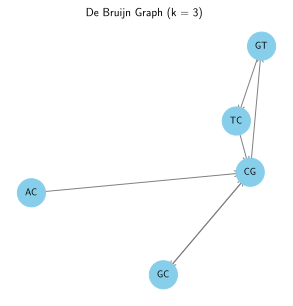

In [42]:
# Example usage:
st = "ACGCGTCG"  # Replace with your actual sequence.
k = 3
visualize_de_bruijn_networkx(st, k)


### What Happens When the Eulerian Graph Goes Wrong?

When building a De Bruijn graph for genome assembly, the goal is to find an Eulerian path (or circuit) that uses each edge exactly once—effectively reconstructing the original sequence from k-mer overlaps. However, several issues can cause the graph to deviate from the ideal Eulerian structure:

1. **Insufficient Coverage or Gaps**  
   - If some parts of the genome are underrepresented (low coverage) or missing entirely (gaps), the corresponding nodes and edges in the graph may not connect properly.  
   - This can break the graph into multiple disconnected components or fail to form a single path spanning all edges.

2. **Sequencing Errors**  
   - Errors in the reads introduce incorrect k-mers, which appear as stray edges or nodes.  
   - These errors can create “dead-end” paths or spurious branches, making it difficult to find a single, correct Eulerian path.

3. **Complex Repeats**  
   - Highly repetitive regions (e.g., large tandem repeats) cause branching in the De Bruijn graph because multiple paths share the same k-mer nodes.  
   - The result can be multiple valid Eulerian paths or ambiguous paths that require additional data or assembly heuristics to resolve.

4. **Imbalance in In-Degree/Out-Degree**  
   - A Eulerian cycle requires each node to have equal in-degree and out-degree. A Eulerian path requires that at most one node has out-degree = in-degree+1 and at most one node has in-degree = out-degree+1, with all other nodes balanced.  
   - If these conditions are not met—say, due to missing edges or spurious edges—there is no valid Eulerian path or cycle.

5. **Multiple Possible Paths**  
   - Even if the graph is Eulerian, there may be branching structures that yield more than one valid path. This ambiguity can lead to multiple possible assemblies unless further information (e.g., paired-end data, long reads, or coverage statistics) helps disambiguate the correct route.

---

### Consequences in Genome Assembly

- **Breaks in Assembly:**  
  If the graph is disconnected or missing edges, the assembly process may produce multiple contigs instead of one contiguous sequence.
  
- **Misassemblies:**  
  If spurious edges or repeats are handled incorrectly, the assembler might merge unrelated regions, leading to chimeric contigs.

- **Need for Additional Heuristics:**  
  Most assembly pipelines incorporate error correction, repeat resolution, or scaffolding techniques (using paired-end or long-read data) to overcome these pitfalls and to “fix” or navigate the graph when it isn’t straightforwardly Eulerian.

In essence, when the Eulerian graph “goes wrong,” it means the underlying data (reads and k-mers) no longer form a clean, single Eulerian path. Assembly algorithms must then apply various heuristics or additional data to resolve these breaks, errors, and ambiguities to reconstruct the most accurate genome sequence possible.


In [ ]:
optimized_scs([])